# Benchmark Comparison: Agent vs VLM Baseline

This notebook compares results from two different approaches:
1. **Agent (Neuro-Symbolic)**: GPT-5.1 with code execution tool calling geometry_tools APIs
2. **VLM Baseline**: GPT-5.1 direct vision-only inference (no tools)

Both benchmarks were run on 750 geometry comparison tasks across different task types.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [2]:
# Load benchmark results
with open('benchmark_agent_42.json', 'r') as f:
    agent_results = json.load(f)

with open('benchmark_results_openai-gpt5_42.json', 'r') as f:
    vlm_results = json.load(f)

print("Agent Benchmark:")
print(f"  Model: {agent_results.get('model', 'N/A')}")
print(f"  Seed: {agent_results.get('seed', 'N/A')}")
print()
print("VLM Baseline:")
print(f"  Model: {vlm_results.get('model', 'N/A')}")
print(f"  Seed: {vlm_results.get('seed', 'N/A')}")

Agent Benchmark:
  Model: N/A
  Seed: N/A

VLM Baseline:
  Model: N/A
  Seed: N/A


## Overall Accuracy Comparison

In [3]:
# Extract overall metrics
agent_overall = agent_results['metrics']['overall']
vlm_overall = vlm_results['metrics']['overall']

print("=" * 50)
print("OVERALL ACCURACY")
print("=" * 50)
print(f"\nAgent (Neuro-Symbolic):  {agent_overall['accuracy']:.1%} ({agent_overall['correct']}/{agent_overall['total']})")
print(f"VLM Baseline:            {vlm_overall['accuracy']:.1%} ({vlm_overall['correct']}/{vlm_overall['total']})")
print(f"\nImprovement: +{(agent_overall['accuracy'] - vlm_overall['accuracy']):.1%}")

OVERALL ACCURACY

Agent (Neuro-Symbolic):  81.6% (612/750)
VLM Baseline:            64.7% (485/750)

Improvement: +16.9%


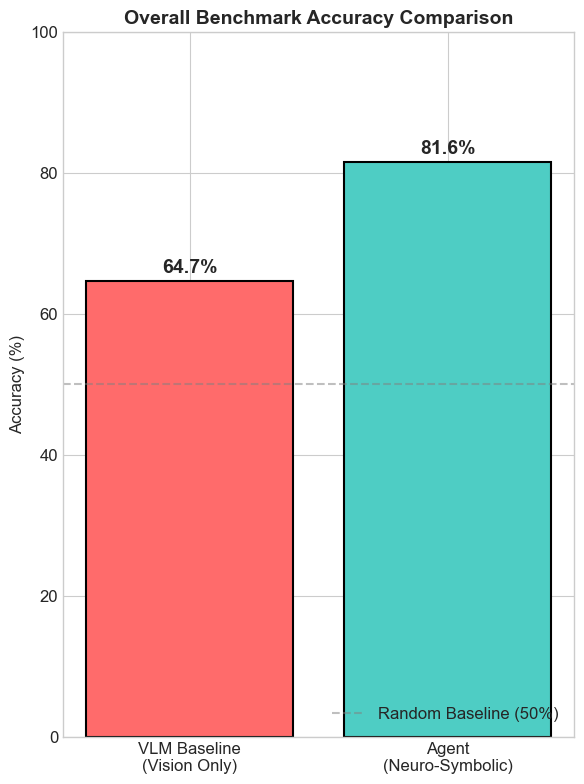

In [15]:
# Overall accuracy bar chart
fig, ax = plt.subplots(figsize=(6, 8))

methods = ['VLM Baseline\n(Vision Only)', 'Agent\n(Neuro-Symbolic)']
accuracies = [vlm_overall['accuracy'] * 100, agent_overall['accuracy'] * 100]
colors = ['#FF6B6B', '#4ECDC4']

bars = ax.bar(methods, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.annotate(f'{acc:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Overall Benchmark Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random Baseline (50%)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('comparison_overall.png', dpi=150, bbox_inches='tight')
plt.show()

## Per-Task Accuracy Comparison

In [5]:
# Extract per-task metrics
agent_by_task = agent_results['metrics']['by_task_type']
vlm_by_task = vlm_results['metrics']['by_task_type']

# Create comparison dataframe
task_types = list(agent_by_task.keys())
comparison_data = []

for task in task_types:
    agent_acc = agent_by_task[task]['accuracy']
    vlm_acc = vlm_by_task[task]['accuracy']
    comparison_data.append({
        'Task': task,
        'Agent': agent_acc * 100,
        'VLM': vlm_acc * 100,
        'Difference': (agent_acc - vlm_acc) * 100,
        'Agent_Correct': agent_by_task[task]['correct'],
        'VLM_Correct': vlm_by_task[task]['correct'],
        'Total': agent_by_task[task]['total']
    })

df = pd.DataFrame(comparison_data)
df = df.sort_values('Difference', ascending=False)
print(df.to_string(index=False))

                   Task      Agent   VLM  Difference  Agent_Correct  VLM_Correct  Total
               1d_arrow 100.000000  50.0   50.000000            100           50    100
              1d_muller  99.333333  50.0   49.333333            149           75    150
                1d_line  78.000000  65.0   13.000000             78           65    100
           2d_rectangle  63.000000  54.0    9.000000             63           54    100
      2d_triangle_right  52.000000  48.0    4.000000             26           24     50
2d_triangle_equilateral  50.000000  48.0    2.000000             25           24     50
              2d_circle  93.000000 100.0   -7.000000             93          100    100
              2d_square  78.000000  93.0  -15.000000             78           93    100


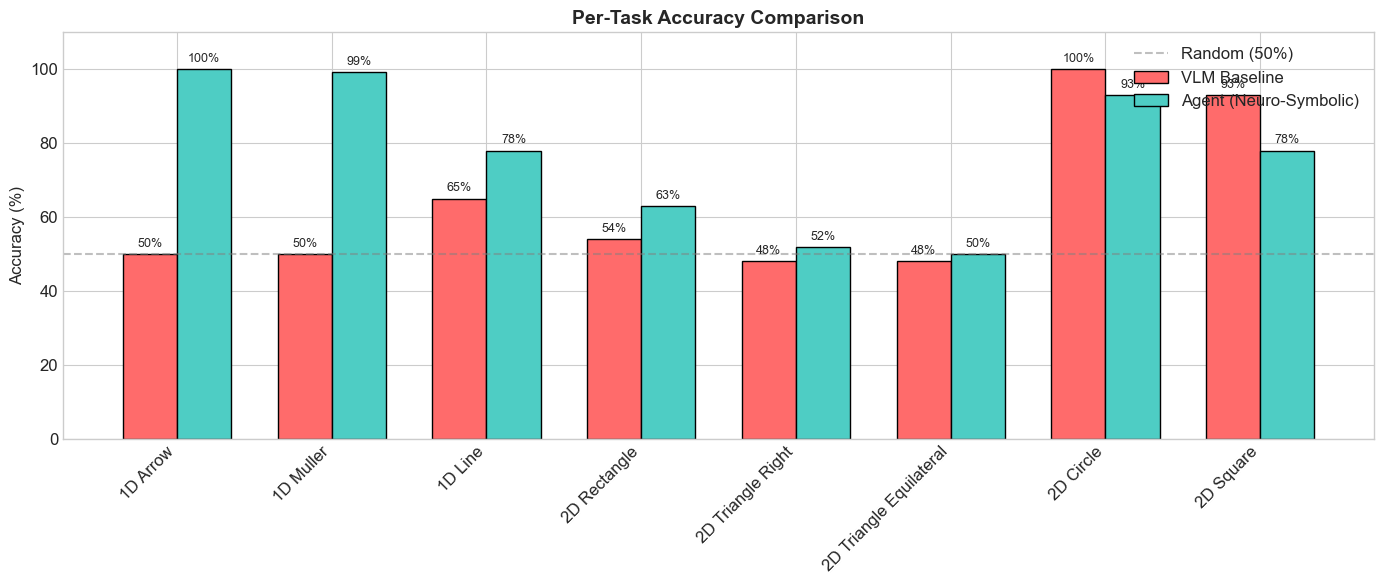

In [16]:
# Grouped bar chart for per-task comparison
fig, ax = plt.subplots(figsize=(14, 6))

# Sort by difference (agent improvement)
df_sorted = df.sort_values('Difference', ascending=False)

x = np.arange(len(df_sorted))
width = 0.35

# Prettier task labels
task_labels = df_sorted['Task'].apply(lambda x: x.replace('_', ' ').title())

bars1 = ax.bar(x - width/2, df_sorted['VLM'], width, label='VLM Baseline', color='#FF6B6B', edgecolor='black')
bars2 = ax.bar(x + width/2, df_sorted['Agent'], width, label='Agent (Neuro-Symbolic)', color='#4ECDC4', edgecolor='black')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Task Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(task_labels, rotation=45, ha='right')
ax.set_ylim(0, 110)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random (50%)')
ax.legend(loc='upper right')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('comparison_by_task.png', dpi=150, bbox_inches='tight')
plt.show()

## Improvement Analysis

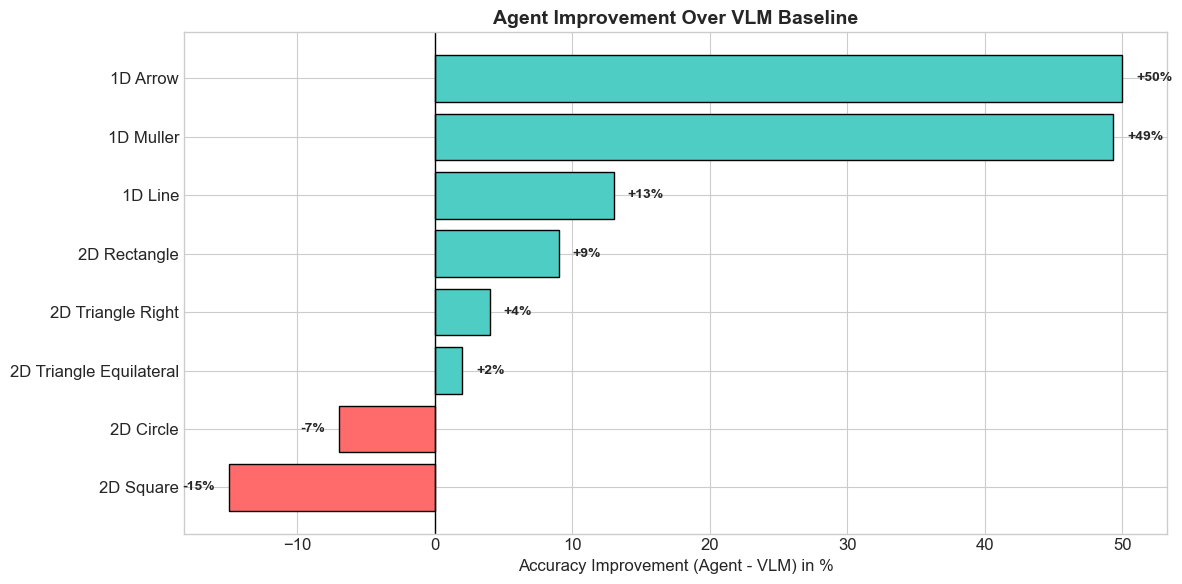

In [7]:
# Improvement chart
fig, ax = plt.subplots(figsize=(12, 6))

df_sorted = df.sort_values('Difference', ascending=True)
colors = ['#FF6B6B' if d < 0 else '#4ECDC4' for d in df_sorted['Difference']]

task_labels = df_sorted['Task'].apply(lambda x: x.replace('_', ' ').title())

bars = ax.barh(task_labels, df_sorted['Difference'], color=colors, edgecolor='black')

ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Accuracy Improvement (Agent - VLM) in %', fontsize=12)
ax.set_title('Agent Improvement Over VLM Baseline', fontsize=14, fontweight='bold')

# Add value labels
for bar, diff in zip(bars, df_sorted['Difference']):
    width_val = bar.get_width()
    label_pos = width_val + 1 if width_val >= 0 else width_val - 1
    ha = 'left' if width_val >= 0 else 'right'
    ax.annotate(f'{diff:+.0f}%',
                xy=(label_pos, bar.get_y() + bar.get_height()/2),
                ha=ha, va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_improvement.png', dpi=150, bbox_inches='tight')
plt.show()

## Task Category Analysis (1D vs 2D)

In [8]:
# Split by 1D and 2D tasks
df['Category'] = df['Task'].apply(lambda x: '1D (Lines)' if x.startswith('1d') else '2D (Shapes)')

# Aggregate by category
category_agg = df.groupby('Category').agg({
    'Agent_Correct': 'sum',
    'VLM_Correct': 'sum',
    'Total': 'sum'
}).reset_index()

category_agg['Agent_Acc'] = category_agg['Agent_Correct'] / category_agg['Total'] * 100
category_agg['VLM_Acc'] = category_agg['VLM_Correct'] / category_agg['Total'] * 100
category_agg['Improvement'] = category_agg['Agent_Acc'] - category_agg['VLM_Acc']

print("\nCategory-Level Analysis:")
print(category_agg.to_string(index=False))


Category-Level Analysis:
   Category  Agent_Correct  VLM_Correct  Total  Agent_Acc   VLM_Acc  Improvement
 1D (Lines)            327          190    350  93.428571 54.285714    39.142857
2D (Shapes)            285          295    400  71.250000 73.750000    -2.500000


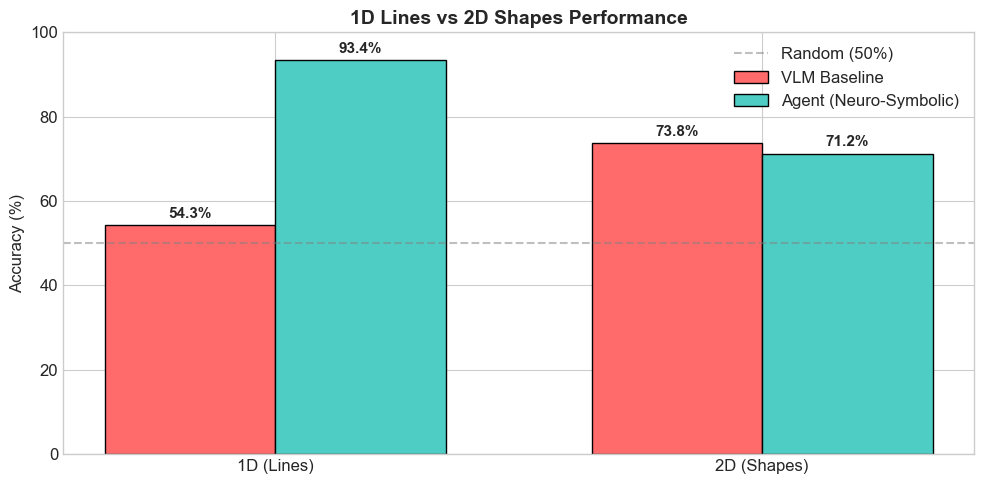

In [9]:
# Category comparison chart
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(category_agg))
width = 0.35

bars1 = ax.bar(x - width/2, category_agg['VLM_Acc'], width, label='VLM Baseline', color='#FF6B6B', edgecolor='black')
bars2 = ax.bar(x + width/2, category_agg['Agent_Acc'], width, label='Agent (Neuro-Symbolic)', color='#4ECDC4', edgecolor='black')

ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('1D Lines vs 2D Shapes Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(category_agg['Category'])
ax.set_ylim(0, 100)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random (50%)')
ax.legend()

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_category.png', dpi=150, bbox_inches='tight')
plt.show()

## Key Insights Summary

In [10]:
print("=" * 60)
print("KEY INSIGHTS SUMMARY")
print("=" * 60)

# Overall improvement
overall_improvement = agent_overall['accuracy'] - vlm_overall['accuracy']
print(f"\n📊 Overall Improvement: +{overall_improvement:.1%}")
print(f"   Agent: {agent_overall['accuracy']:.1%} vs VLM: {vlm_overall['accuracy']:.1%}")

# Best improvements
print("\n🚀 Biggest Agent Improvements:")
top_improvements = df.nlargest(3, 'Difference')
for _, row in top_improvements.iterrows():
    print(f"   • {row['Task']}: +{row['Difference']:.0f}% ({row['VLM']:.0f}% → {row['Agent']:.0f}%)")

# VLM better
vlm_better = df[df['Difference'] < 0]
if len(vlm_better) > 0:
    print("\n⚠️ Tasks where VLM performed better:")
    for _, row in vlm_better.iterrows():
        print(f"   • {row['Task']}: {row['Difference']:.0f}% ({row['Agent']:.0f}% vs {row['VLM']:.0f}%)")

# Optical illusion resistance
muller_agent = agent_by_task['1d_muller']['accuracy']
muller_vlm = vlm_by_task['1d_muller']['accuracy']
print(f"\n🔬 Optical Illusion Resistance (Müller-Lyer):")
print(f"   Agent: {muller_agent:.1%} vs VLM: {muller_vlm:.1%}")
print(f"   → Agent is {muller_agent/muller_vlm:.1f}x more accurate on illusions!")

# Perfect scores
perfect_agent = df[df['Agent'] == 100]['Task'].tolist()
perfect_vlm = df[df['VLM'] == 100]['Task'].tolist()
print(f"\n✅ Perfect Scores (100%):")
print(f"   Agent: {perfect_agent if perfect_agent else 'None'}")
print(f"   VLM: {perfect_vlm if perfect_vlm else 'None'}")

KEY INSIGHTS SUMMARY

📊 Overall Improvement: +16.9%
   Agent: 81.6% vs VLM: 64.7%

🚀 Biggest Agent Improvements:
   • 1d_arrow: +50% (50% → 100%)
   • 1d_muller: +49% (50% → 99%)
   • 1d_line: +13% (65% → 78%)

⚠️ Tasks where VLM performed better:
   • 2d_circle: -7% (93% vs 100%)
   • 2d_square: -15% (78% vs 93%)

🔬 Optical Illusion Resistance (Müller-Lyer):
   Agent: 99.3% vs VLM: 50.0%
   → Agent is 2.0x more accurate on illusions!

✅ Perfect Scores (100%):
   Agent: ['1d_arrow']
   VLM: ['2d_circle']


## Summary Table

In [11]:
# Create a clean summary table
summary_df = df[['Task', 'VLM', 'Agent', 'Difference']].copy()
summary_df.columns = ['Task Type', 'VLM Baseline (%)', 'Agent (%)', 'Δ (%)']
summary_df = summary_df.sort_values('Task Type')

# Style the dataframe
def color_improvement(val):
    if val > 0:
        return f'color: green; font-weight: bold'
    elif val < 0:
        return f'color: red; font-weight: bold'
    return ''

styled = summary_df.style.applymap(color_improvement, subset=['Δ (%)'])
styled = styled.format({'VLM Baseline (%)': '{:.1f}', 'Agent (%)': '{:.1f}', 'Δ (%)': '{:+.1f}'})
styled

/var/folders/jj/4r8dblf53l9_ssdctfrstl480000gn/T/ipykernel_47574/322101355.py:14: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = summary_df.style.applymap(color_improvement, subset=['Δ (%)'])


,Task Type,VLM Baseline (%),Agent (%),Δ (%)
3,1d_arrow,50.0,100.0,+50.0
2,1d_line,65.0,78.0,+13.0
5,1d_muller,50.0,99.3,+49.3
7,2d_circle,100.0,93.0,-7.0
1,2d_rectangle,54.0,63.0,+9.0
0,2d_square,93.0,78.0,-15.0
6,2d_triangle_equilateral,48.0,50.0,+2.0
4,2d_triangle_right,48.0,52.0,+4.0
